In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
#paramns
radios_validate = 10
high_limit = 0
# feature_analyse = 'reflection'
# feature_analyse = 'pupil_occlusion'
# feature_analyse = 'blur'
# feature_analyse = 'same_shade'
feature_analyse = 'no_features'

In [3]:
path_labels = "D:\\Projects\\Results\\ResultsPPL,CenterPupil,DeepRN,ExCuSe"
path_features = "\\".join([path_labels,  "Features\\features.csv"])
path_label_label = '\\'.join([path_labels, "Label\\label.csv"])
path_label_PPL = '\\'.join([path_labels, "AlgoPPL\\label.csv"])
path_label_CenterPupilTec1 = '\\'.join([path_labels, "CenterPupilTec1\\label.csv"])
path_label_CenterPupilTec2 = '\\'.join([path_labels, "CenterPupilTec2\\label.csv"])
path_label_DeepRN = '\\'.join([path_labels, "DeepRN\\label.csv"])
path_label_ExCuSe = '\\'.join([path_labels, "ExCuSe\\label.csv"])

In [4]:
features = pd.read_csv(path_features)
label_label = pd.read_csv(path_label_label)
label_PPL = pd.read_csv(path_label_PPL)
label_tec1 = pd.read_csv(path_label_CenterPupilTec1)
label_tec2 = pd.read_csv(path_label_CenterPupilTec2)
label_deepRN = pd.read_csv(path_label_DeepRN)
label_excuse = pd.read_csv(path_label_ExCuSe)

In [5]:
print(set(features['kind_of_fail'].to_list()))

{'same_shade', 'reflection', 'pupil_occlusion', 'no_features', 'blur'}


In [6]:
label_excuse['n_frame'] = [int(tmp[0].replace('.png', '')) for tmp in label_excuse.values]
label_excuse = label_excuse.sort_values(by=['n_frame'], axis=0)
label_excuse = label_excuse.reset_index(drop=True)

In [7]:
def mensure_distance(label, center_estimate, return_bool=True):
    square = ((center_estimate[0] - label[0]) ** 2) + ((center_estimate[1] - label[1]) ** 2)
    square = math.sqrt(square)
    return square < radios_validate, square

In [8]:
# Massive process mensure scores and create graphs

score_ppl, score_tec1, score_tec2, score_deepRN, score_excuse = pd.Series([0]), pd.Series([0]), pd.Series([0]), pd.Series([0]), pd.Series([0])
last_ppl, last_tec1, last_tec2, last_deepRN, last_excuse = 0, 0, 0, 0, 0
last_score_ppl, last_score_tec1, last_score_tec2, last_score_deepRN, last_score_excuse = 0, 0, 0, 0, 0

for index in range(features.shape[0]):
    if features['kind_of_fail'][index] != feature_analyse:
        continue
    
    center_label = int(label_label["center_x"][index]), int(label_label["center_y"][index])
    center_ppl = int(label_PPL["center_x"][index]), int(label_PPL["center_y"][index])
    center_tec1 = int(label_tec1["center_x"][index]), int(label_tec1["center_y"][index])
    center_tec2 = int(label_tec2["center_x"][index]), int(label_tec2["center_y"][index])
    center_deepRN = int(label_deepRN["center_x"][index]), int(label_deepRN["center_y"][index])
    center_excuse = int(label_excuse["position_y"][index]), int(label_excuse["position_x"][index])
    
    # Measure distance and set correct or incorrect predict of algorithm
    # -------------------
    v_ppl = mensure_distance(center_label, center_ppl)[1]
    if v_ppl < radios_validate:
        v_ppl = 0.0
        last_score_ppl += 1
    
    v_tec1 = mensure_distance(center_label, center_tec1)[1]
    if v_tec1 < radios_validate:
        v_tec1 = 0.0
        last_score_tec1 += 1
    
    v_tec2 = mensure_distance(center_label, center_tec2)[1]
    if v_tec2 < radios_validate:
        v_tec2 = 0.0
        last_score_tec2 += 1
        
    v_deepRN = mensure_distance(center_label, center_deepRN)[1]
    if v_deepRN < radios_validate:
        v_deepRN = 0.0
        last_score_deepRN += 1
        
    v_excuse = mensure_distance(center_label, center_excuse)[1]
    if v_excuse < radios_validate:
        v_excuse = 0.0
        last_score_excuse += 1
        
        
    # Test limits of distance, 1-converge margem to high_limit; 2-sky of limit
    # -------------------
    if high_limit > 0:
        v_ppl = last_ppl + v_ppl if v_ppl < high_limit else last_ppl + high_limit
        v_tec1 = last_tec1 + v_tec1 if v_tec1 < high_limit else last_tec1 + high_limit
        v_tec2 = last_tec2 + v_tec2 if v_tec2 < high_limit else last_tec2 + high_limit
        v_deepRN = last_deepRN + v_deepRN if v_deepRN < high_limit else last_deepRN + high_limit        
        v_excuse = last_excuse + v_excuse if v_excuse < high_limit else last_excuse + high_limit
    else:
        v_ppl = last_ppl + v_ppl
        v_tec1 = last_tec1 + v_tec1
        v_tec2 = last_tec2 + v_tec2
        v_deepRN = last_deepRN + v_deepRN
        v_excuse = last_excuse + v_excuse

        
    # Save last values
    # -------------------
    last_ppl = v_ppl
    last_tec1 = v_tec1
    last_tec2 = v_tec2
    last_deepRN = v_deepRN
    last_excuse = v_excuse    
    
    
    # Fill distance and score lists
    # -------------------   
    score_ppl = score_ppl.append(pd.Series(last_score_ppl))
    score_tec1 = score_tec1.append(pd.Series(last_score_tec1))
    score_tec2 = score_tec2.append(pd.Series(last_score_tec2))
    score_deepRN = score_deepRN.append(pd.Series(last_score_deepRN))
    score_excuse = score_excuse.append(pd.Series(last_score_excuse))

In [9]:
# Rearange lists of scores
list_score_ppl = pd.Series(score_ppl, name="PPL Algorithm").reset_index().drop(['index'], axis=1)
list_score_tec1 = pd.Series(score_tec1, name="CenterPupil - Tec1 Algorithm").reset_index().drop(['index'], axis=1)
list_score_tec2 = pd.Series(score_tec2, name="CenterPupil - Tec2 Algorithm").reset_index().drop(['index'], axis=1)
list_score_deepRN = pd.Series(score_deepRN, name="DeepRN Algorithm").reset_index().drop(['index'], axis=1)
list_score_excuse = pd.Series(score_excuse, name="ExCuSe Algorithm").reset_index().drop(['index'], axis=1)

print(list_score_ppl[0:5])
print(list_score_tec1[0:5])
print(list_score_tec2[0:5])
print(list_score_deepRN[0:5])
print(list_score_excuse[0:5])

print(list_score_ppl.shape, list_score_tec1.shape, list_score_tec2.shape, list_score_deepRN.shape, list_score_excuse.shape)
print(type(list_score_ppl), type(list_score_tec1), type(list_score_tec2), type(list_score_deepRN), type(list_score_excuse))

   PPL Algorithm
0              0
1              0
2              0
3              0
4              0
   CenterPupil - Tec1 Algorithm
0                             0
1                             1
2                             2
3                             3
4                             4
   CenterPupil - Tec2 Algorithm
0                             0
1                             1
2                             2
3                             3
4                             4
   DeepRN Algorithm
0                 0
1                 1
2                 2
3                 3
4                 4
   ExCuSe Algorithm
0                 0
1                 0
2                 0
3                 0
4                 0
(2840, 1) (2840, 1) (2840, 1) (2840, 1) (2840, 1)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [10]:
# Create a dataset of scores

if feature_analyse == 'reflection':
    feature_text = 'Reflection'
elif feature_analyse == 'same_shade':
    feature_text = 'Same Shade'
elif feature_analyse == 'no_features':
    feature_text = 'No Features'
elif feature_analyse == 'pupil_occlusion':
    feature_text = 'Pupil Occlusion'
elif feature_analyse == 'blur':
    feature_text = 'Blur'
else:
    feature_text = 'No Identify'

text_1 = 'Quantity Frames of {}'.format(feature_text)
text_2 = 'Algorithm'
text_3 = 'Score'

data_score = pd.DataFrame({text_1: [0], text_2: ['PPL Algorithm'], text_3: [list_score_ppl.iloc[0][0]]})
data_score = data_score.append({text_1: 0, text_2: 'CenterPupil - Tec1 Algorithm', text_3: list_score_tec1.iloc[0][0]}, ignore_index=True)
data_score = data_score.append({text_1: 0, text_2: 'CenterPupil - Tec2 Algorithm', text_3: list_score_tec2.iloc[0][0]}, ignore_index=True)
data_score = data_score.append({text_1: 0, text_2: 'DeepRN Algorithm', text_3: list_score_deepRN.iloc[0][0]}, ignore_index=True)
data_score = data_score.append({text_1: 0, text_2: 'ExCuSe Algorithm', text_3: list_score_excuse.iloc[0][0]}, ignore_index=True)

for frame in range(1, list_score_deepRN.shape[0]):
    data_score = data_score.append({text_1: frame, text_2: 'PPL Algorithm', text_3: list_score_ppl.iloc[frame][0]}, ignore_index=True)
    data_score = data_score.append({text_1: frame, text_2: 'CenterPupil - Tec1 Algorithm', text_3: list_score_tec1.iloc[frame][0]}, ignore_index=True)
    data_score = data_score.append({text_1: frame, text_2: 'CenterPupil - Tec2 Algorithm', text_3: list_score_tec2.iloc[frame][0]}, ignore_index=True)
    data_score = data_score.append({text_1: frame, text_2: 'DeepRN Algorithm', text_3: list_score_deepRN.iloc[frame][0]}, ignore_index=True)
    data_score = data_score.append({text_1: frame, text_2: 'ExCuSe Algorithm', text_3: list_score_excuse.iloc[frame][0]}, ignore_index=True)
    
print(data_score.values)

[[0 'PPL Algorithm' 0]
 [0 'CenterPupil - Tec1 Algorithm' 0]
 [0 'CenterPupil - Tec2 Algorithm' 0]
 ...
 [2839 'CenterPupil - Tec2 Algorithm' 1755]
 [2839 'DeepRN Algorithm' 2825]
 [2839 'ExCuSe Algorithm' 620]]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


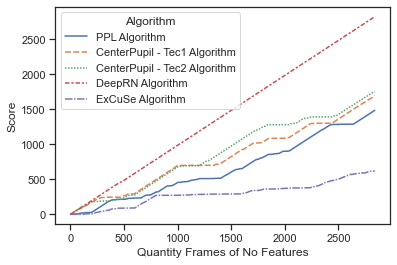

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set_theme(style="darkgrid")
sns.set_theme(style="ticks")

sns_plot = sns.lineplot(data=data_score, x=text_1, y=text_3, hue=text_2, style=text_2)
fig = sns_plot.get_figure()

name_fig = '{}\\Compare_Scores_Algorithm_Features_{}.eps'.format(path_labels, feature_analyse)
fig.savefig(name_fig, format='eps', dpi=1200, bbox_inches='tight')
fig.savefig(name_fig.replace('.eps', '.png'), format='png', dpi=1200, bbox_inches='tight')

In [12]:
out_label = "\\".join([path_labels, "scores_features.txt"])

acc_ppl = (score_ppl.max()/score_ppl.shape[0])*100
acc_tec1 = (score_tec1.max()/score_tec1.shape[0])*100
acc_tec2 = (score_tec2.max()/score_tec2.shape[0])*100
acc_deepRN = (score_deepRN.max()/score_deepRN.shape[0])*100
acc_excuse = (score_excuse.max()/score_excuse.shape[0])*100

with open(out_label, 'a') as file_write:
    text_write = '{} - ppl: %.4f; tec1: %.4f; tec2: %.4f; deepRN: %.4f; ExCuse: %.4f'.format(feature_text) % (acc_ppl,
                                                                                                              acc_tec1,
                                                                                                              acc_tec2,
                                                                                                              acc_deepRN,
                                                                                                              acc_excuse)
    file_write.write(text_write)

In [28]:
# Create a dataset of scores

max_reflection, max_same_shade, max_no_features, max_pupil_occlusion, max_blur = 0, 0, 0, 0, 0


if features['kind_of_fail'][0] == 'reflection':
    max_reflection += 1
elif features['kind_of_fail'][0] == 'same_shade':
    max_same_shade += 1
elif features['kind_of_fail'][0] == 'no_features':
    max_no_features += 1
elif features['kind_of_fail'][0] == 'pupil_occlusion':
    max_pupil_occlusion += 1
elif features['kind_of_fail'][0] == 'blur':
    max_blur += 1

data_features = pd.DataFrame({'Frame': [0], 'Reflection': [max_reflection], 'Same Shade': [max_same_shade],
                              'No Features': [max_no_features], 'Pupil Occlusion': [max_pupil_occlusion],
                              'Blur': [max_blur]})

for index in range(1, features.shape[0]):
    if features['kind_of_fail'][index] == 'reflection':
        max_reflection += 1
    elif features['kind_of_fail'][index] == 'same_shade':
        max_same_shade += 1
    elif features['kind_of_fail'][index] == 'no_features':
        max_no_features += 1
    elif features['kind_of_fail'][index] == 'pupil_occlusion':
        max_pupil_occlusion += 1
    elif features['kind_of_fail'][index] == 'blur':
        max_blur += 1
    
    data_features = data_features.append({'Frame': index, 'Reflection': max_reflection, 'Same Shade': max_same_shade,
                                          'No Features': max_no_features, 'Pupil Occlusion': max_pupil_occlusion,
                                          'Blur': max_blur}, ignore_index=True)
    
print(data_features)

      Frame  Reflection  Same Shade  No Features  Pupil Occlusion  Blur
0         0           0           0            1                0     0
1         1           0           0            2                0     0
2         2           0           0            3                0     0
3         3           0           0            4                0     0
4         4           0           0            5                0     0
...     ...         ...         ...          ...              ...   ...
4395   4395         200         160         2835              201  1000
4396   4396         200         160         2836              201  1000
4397   4397         200         160         2837              201  1000
4398   4398         200         160         2838              201  1000
4399   4399         200         160         2839              201  1000

[4400 rows x 6 columns]


                    Frame  Reflection  Same Shade  No Features  \
Frame            1.000000    0.870857    0.867264     0.986606   
Reflection       0.870857    1.000000    0.774536     0.853834   
Same Shade       0.867264    0.774536    1.000000     0.840159   
No Features      0.986606    0.853834    0.840159     1.000000   
Pupil Occlusion  0.572227    0.330803    0.437944     0.510010   
Blur             0.956346    0.803124    0.812515     0.902959   

                 Pupil Occlusion      Blur  
Frame                   0.572227  0.956346  
Reflection              0.330803  0.803124  
Same Shade              0.437944  0.812515  
No Features             0.510010  0.902959  
Pupil Occlusion         1.000000  0.603008  
Blur                    0.603008  1.000000  
[[ True  True  True  True  True  True]
 [False  True  True  True  True  True]
 [False False  True  True  True  True]
 [False False False  True  True  True]
 [False False False False  True  True]
 [False False False False F

<AxesSubplot:>

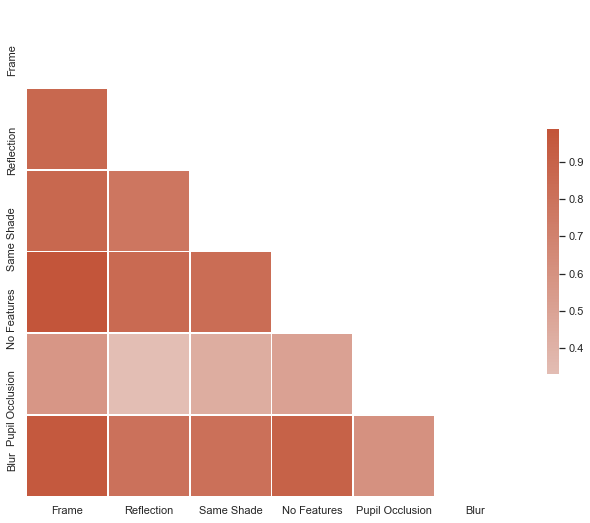

In [31]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

corr = data_features.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
print(corr)
print(mask)

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})